# Spike distance

In [4]:
from neo.core import SpikeTrain
from quantities import ms
import numpy as np
import pickle
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
import matplotlib.patches as patches
import h5py
from scipy.signal import convolve
from scipy.interpolate import griddata
import pickle
import pandas as pd
from scipy.stats import ttest_ind
def compute_emd_matrix(spike_trains):
    """
    Compute a pairwise EMD distance matrix for a list of spike trains.
    
    Parameters:
        spike_trains: list of lists, where each sublist is a spike train
    
    Returns:
        emd_matrix: 2D numpy array of shape (N, N) with pairwise EMD values
    """
    num_trials = len(spike_trains)
    emd_matrix = np.zeros((num_trials, num_trials))

    for i in range(num_trials):
        for j in range(i + 1, num_trials):  # Only compute upper triangle
            emd = wasserstein_distance(spike_trains[i], spike_trains[j])
            emd_matrix[i, j] = emd
            emd_matrix[j, i] = emd  # Symmetric matrix

    return emd_matrix

def plot_matrix(matrix, title="Pairwise EMD Distance Matrix"):
    """
    Plots a matrix as a heatmap using Matplotlib.

    Parameters:
        matrix: 2D numpy array to be visualized.
        title: Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar(label="EMD Distance")
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Trial Index")
    plt.show()
    
def block_means(matrix,n_groups, group_size):
# Initialize an array to store the averaged values.
    block_means = np.zeros((n_groups, n_groups))

    # Loop through each block, compute its mean, and store it.
    for i in range(n_groups):
        for j in range(n_groups):
            
            block = matrix[i*group_size:(i+1)*group_size, j*group_size:(j+1)*group_size]
            # Compute the average of the block.
            block_means[i, j] = block.mean()
    return block_means

def block_stats_all(matrix, n_real):


    real_real   = matrix[:n_real,   :n_real].ravel()
    real_model  = matrix[:n_real,   n_real:].ravel()
    model_model = matrix[n_real:, n_real:].ravel() 
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        # stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
        stats.append({
            "label": label,
            "mean":  mean_val,
            "range": range_val,
            "std":   std_val,
            "cv":    cv_val,
            "data":  block
        })


    return stats

def plot_matrixcat_and_stats(matrix, title="Pairwise EMD Distance Matrix", n_real=None, n_model=None, group_size=None):

    # Total number of trials (columns)
    N = matrix.shape[1]
    if n_real is None or n_model is None:
        n_real = N // 2
        n_model = N - n_real

    # Create the main heatmap with colorbar.
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(matrix, cmap="coolwarm", aspect="auto")
    ax.set_xlabel("Trial Index")
    ax.set_ylabel("Trial Index")
    ax.set_title(title, fontsize=20, pad=40)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="EMD Distance")

    # Get the position of the heatmap axis.
    pos = ax.get_position()
    gap_val = 0.005         # Vertical gap between the heatmap and the category bar.
    cat_bar_height = 0.03     # Height of the category bar.

    # Create a new axis above the heatmap for the category bar.
    cat_ax = fig.add_axes((pos.x0, pos.y0 + pos.height + gap_val, pos.width, cat_bar_height))
    cat_ax.set_xlim(0, N)
    cat_ax.set_ylim(0, 1)
    cat_ax.axis("off")

    # Define a gap (in trial units) between the two black bars.
    gap = 2  
    real_width = n_real - gap / 2
    model_width = n_model - gap / 2

    # Draw the "Real" bar (black) covering the real trials.
    cat_ax.add_patch(patches.Rectangle((0, 0), real_width, 0.21, facecolor="black"))
    # Draw the "Model" bar (black) covering the model trials.
    cat_ax.add_patch(patches.Rectangle((n_real + gap/2, 0), model_width, 0.21, facecolor="black"))

    # Add text labels over each bar.
    cat_ax.text(real_width / 2, 0.5, "Real", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")
    cat_ax.text(n_real + gap/2 + model_width / 2, 0.5, "Model", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")

    # Create an axis for the statistics table below the heatmap.
    table_height = 0.15  # Adjust table height as needed.
    table_ax = fig.add_axes((pos.x0, pos.y0 - table_height - 0.2, pos.width, table_height))
    table_ax.axis('off')
    
    # Compute block statistics for three blocks.
    stats = block_stats_all(matrix, n_real)
    column_labels = ["Block", "Mean", "Range", "Std", "CV"]
    
    # Convert stats to proper table format
    cell_text = []
    for stat in stats:
        cell_text.append([
            stat["label"],
            f"{stat['mean']:.2f}",
            f"{stat['range']:.2f}",
            f"{stat['std']:.2f}",
            f"{stat['cv']:.2f}"
        ])
    table = table_ax.table(cellText=cell_text, colLabels=column_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(True)
    # table.set_fontsize(14)
    table.scale(1, 1.2)
    table_ax.set_title("Block Statistics", fontsize=20, pad=20)
    
    plt.show()






def generate_stimuli(trajx, trajy,board_size=400, diameter=30,fps = 60,pretime = 50,tailtime =50,type='natural',preframes=15,tailframes=45,stimframes=15):
    stimuli = []
    dt = 1/fps

    board_range = [-(board_size/2), (board_size/2)]  
    radius = diameter / 2  

    x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    if type == 'natural':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

        preframenum = int(pretime / 1000 /dt)
        tailframenum = int(tailtime / 1000 /dt)
        for _ in range(preframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
        
        for frame_idx, (x, y) in enumerate(zip(trajx, trajy)):
            # if frame_idx < preframenum or frame_idx >= (len(trajx) - tailframenum):
            #     # Draw blank
            #     frame = np.zeros((board_size, board_size), dtype=np.uint8)
            # else:
                # Draw the circle
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1

            stimuli.append(frame)   
            
        for _ in range(tailframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
    if type == 'spotfield':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

    
        for section_idx, (x, y) in enumerate(zip(trajx, trajy)):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(preframes):
                stimuli.append(frame)   
                
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1
            for _ in range(stimframes):
                stimuli.append(frame)   
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(tailframes):
                stimuli.append(frame)   
        
    return np.array(stimuli)


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=1, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

def gaussian_2dflatten(x, y, sigma_x, sigma_y,mix, widenratio, A=1, x0=0, y0=0):
    A = gaussian_2d(x=x, y=y, sigma_x = sigma_x, sigma_y = sigma_y, A=A, x0=x0, y0=y0) + gaussian_2d(x=x, y=y, sigma_x = widenratio* sigma_x, sigma_y = widenratio*sigma_y, A=mix*A, x0=x0, y0=y0)
    A = A / np.max(A)
    return A 

def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround
def generalized_gaussian_2d(x, y, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0):
    """
    2D generalized Gaussian with exponent alpha:
    - alpha = 1: standard Gaussian
    - 0 < alpha < 1: heavier tails (higher kurtosis)
    - alpha > 1: lighter tails
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    Q = ((X - x0)**2 / (2 * sigma_x**2) +
         (Y - y0)**2 / (2 * sigma_y**2))
    d = A * np.exp(- Q**alpha)
    d = d / d[int((len(x)-1)/2),int((len(x)-1)/2+1)]
    return d   # Normalize to max value of 1

# 2) Student's-t / Cauchy-style kernel
def student_t_2d(x, y, sigma_x, sigma_y, nu, A=1.0, x0=0, y0=0):
    """
    2D Student's-t distribution (heavy-tailed):
    - nu: degrees of freedom. Lower nu -> heavier tails
    - For nu=1: Cauchy (Lorentzian) form
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    r2 = ((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2)
    return A * (1 + r2 / nu) ** (-(nu + 1) / 2)
def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   

    T, Y, X = noise_input.shape 
    # x = np.linspace(-(X-1)/2, (X-1)/2, X)
    # y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    # if type == 'gaussian':
    #     spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    # if type == 'difference_of_gaussians':
    #     spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    # if type == 'SFfitting':
    #     spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    # if type == 'gaussian_2dflatten':
    #     spatial_rf = gaussian_2dflatten(x, y, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    



# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


rf_estimated = np.load('results/rf_estimated.npy')
with open('results/spike_trainGC.pkl', 'rb') as f:
    spike_trainGC = pickle.load(f)


with open('results/spike_indices_n.pkl', 'rb') as f:
    spike_indices_n = pickle.load(f)

with open('results/spike_indices_c.pkl', 'rb') as f:
    spike_indices_c = pickle.load(f)



spike_indicesModified_n = spike_indices_n.copy()
spike_indicesModified_c = spike_indices_c.copy()
spike_indicesModified_n[4] = spike_indices_n[4]-800
spike_indicesModified_n[45] = spike_indices_n[45]-800
spike_indicesModified_c[34] = spike_indices_c[34]-800

# model PARAM

In [5]:
delay = 0.083 # s
q = 1.0 / (100.0 * pq.ms)
# Parameter settting for model
temporal_filter_noise = np.load('results/temporal_filter5.npy')
reversed_temp_rfTemp = temporal_filter_noise[::-1]
stimuli_n = np.load('results/stimuli_n.npy')
stimuli_c = np.load('results/stimuli_c.npy')
# parameters for the LN-GC 
time_para = 5400 # time bin to generate spike
time_bin = 1/time_para
num_modeltrails = 60 #
A = 1
stimttype = 'natural_gaussian' # 'natural', 'control', 'movingobject', 'natural_gaussian', 'natural_w/o_gaincontrol', 'natural_gaussianflatten'



# Spike distance and raster

In [ ]:
# Define all stimttype configurations
stimttypes = [
    'natural', 'control', 'natural_gaussian', 'control_gaussian',
    'natural_w/o_gaincontrol', 'control_w/o_gaincontrol',
    'natural_gaussianflatten', 'control_gaussianflatten',
    'natural_gaussianGen', 'control_gaussianGen',
    'natural_student_t', 'control_student_t'
]

# Store all results
all_results = {}

# Loop through each stimttype
for stimttype in stimttypes:
    print(f"Running analysis for {stimttype}...")
    
    # Set the stimttype variable
    stimttype = stimttype
    
    # NOW MANUALLY RUN YOUR EXISTING CELLS:

    if stimttype == 'natural':

        stimuli = stimuli_n
        spike_indices = spike_indicesModified_n
        t_sampling = np.linspace(0,1860,1860)
        B       = 6.411158754233981e-05
        tau     = 15
        gain    = 0.004842012445479653
        max_rate = 162.37622765580858
        y = 39.19650036855157
        theta = 94.75990467836039

        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
        
    if stimttype == 'control':

        stimuli = stimuli_c
        spike_indices = spike_indicesModified_c
        t_sampling = np.linspace(0,1860,1860)
        B       = 0.00011715572903984658
        tau     = 4.458
        gain    = 0.008597688603542503
        max_rate = 167.78127895740027
        y = -119.83766527852671
        theta = 93.52615542226813

        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)

    if stimttype == 'natural_gaussian':

        stimuli = stimuli_n
        spike_indices = spike_indicesModified_n
        t_sampling = np.linspace(0,1860,1860)
        sigma_x, sigma_y = 26.238239449881775, 26.238239449881775
        B       = 0.0005890840929298896
        tau     = 5
        gain    = 0.004941576728320853
        max_rate = 159.41500089088095
        y = 48.02014055973967
        theta = 89.85336019063443


        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)


    if stimttype == 'control_gaussian':

        stimuli = stimuli_c
        spike_indices = spike_indicesModified_c
        t_sampling = np.linspace(0,1860,1860)
        sigma_x, sigma_y = 24.6645, 24.6645
        B       = 6.3e-05
        tau     = 7
        gain    = 0.0062374
        max_rate = 153.341
        y = 1.8995
        theta = 85.133
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    if stimttype == 'natural_w/o_gaincontrol':

        stimuli = stimuli_n
        spike_indices = spike_indicesModified_n
        t_sampling = np.linspace(0,1860,1860)
        B = 0
        tau =1
        gain    = 0.009294318791784825
        max_rate = 161.24621441310256
        y = 37.96610100821994
        theta = 97.94123428565233
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    if stimttype == 'control_w/o_gaincontrol':

        stimuli = stimuli_c
        spike_indices = spike_indicesModified_c
        t_sampling = np.linspace(0,1860,1860)
        B = 0 
        tau =1
        gain    = 0.003491333021374965
        max_rate = 174.96921876706517
        y = -23.654739030581368
        theta = 85.15827135305307
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    if stimttype == 'natural_gaussianflatten':

        stimuli = stimuli_n
        spike_indices = spike_indicesModified_n

        t_sampling = np.linspace(0,1860,1860)

        sigma_x,sigma_y = 14.179272158805905,14.179272158805905
        B       = 0.0006058055592789192
        tau     = 14
        mix     = 0.3544483815254731
        widenratio = 3.132761307300863
        gain    = 0.004545293796018254
        max_rate = 187.8839335009455
        y = -190.96937964264328
        theta = 62.14539986205705
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    if stimttype == 'control_gaussianflatten':

        stimuli = stimuli_c
        spike_indices = spike_indicesModified_c

        t_sampling = np.linspace(0,1860,1860)

        sigma_x,sigma_y   = 12.271325068425213,12.271325068425213
        B       = 0.0007810624726927833
        tau     = 7
        mix     = 0.49275070289612133
        widenratio = 3.2885788095100805
        gain    = 0.005167895796580307
        max_rate = 181.81073029192413
        y = -84.77972253021717
        theta = 79.69957192815914

        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)

    if stimttype == 'natural_gaussianGen':
        stimuli = stimuli_n
        spike_indices = spike_indicesModified_n

        t_sampling = np.linspace(0,1860,1860)
        sigma_x, sigma_y = 17.47092326245375, 17.47092326245375
        B       = 0.0020726650171981505
        tau     = 8
        alpha   = 0.6406881081699589
        gain    = 0.0067756980878963535
        max_rate = 159.9339258354442
        y = -21.160840485288347
        theta = 74.43809001411122
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)

        spatial_rf = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)
        spatial_rf_gaussGenNat =generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)

    if stimttype == 'control_gaussianGen':
        stimuli = stimuli_c
        spike_indices = spike_indicesModified_c
        t_sampling = np.linspace(0,1860,1860)

        sigma_x,sigma_y = 19.236720868702694,19.236720868702694
        B       = 0.0005699
        tau     = 6
        alpha   = 0.6546156922496472
        gain    = 0.008351077202947548
        max_rate = 170.6176092399276
        y = -79.68722771262551
        theta = 80.52951256652139

        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)

        spatial_rf = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)
        spatial_rf_gaussGenCon =generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)
    

    if stimttype == 'natural_student_t':
        stimuli = stimuli_n
        spike_indices = spike_indicesModified_n
        t_sampling = np.linspace(0,1860,1860)


        sigma_x,sigma_y = 14.916074929510014,14.916074929510014
        B       = 0.002840541356499131
        tau     = 5.061818526494731
        nu      = 0.9911028986301904
        gain    = 0.008882754610280263
        max_rate = 197.7624061798797
        y = -18.452088835880147
        theta = 91.32321642514742
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
        spatial_rf_student_tNat = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)

    if stimttype == 'control_student_t':
        stimuli = stimuli_c
        spike_indices = spike_indicesModified_c
        t_sampling = np.linspace(0,1860,1860)
        sigma_x,sigma_y = 19.029,19.029
        B       = 0.00105959
        tau     = 6
        nu      = 1.5659527057147167
        gain    = 0.005387110123236081
        max_rate = 204.2292354819619
        y = -42.899625911306494
        theta = 92.86965584673743
        T, X_SF, Y_SF = stimuli.shape 
        x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
        y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
        spatial_rf = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
        spatial_rf_student_tCon = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)


    # LN model
    spike_trainLN = []
    LoutLN = linear_filter(spatial_rf, stimuli, reversed_temp_rfTemp)
    LNoutLN = apply_nonlinearity(apply_nonlinearity(LoutLN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)


    for trial in range(num_modeltrails):
        spikingindx=(resample_and_generate_spikes(LNoutLN, time_bin))
        spike_trainLN.append(np.where(spikingindx > 0))


    #LN model with gain control
    spike_trainGC = []
    LoutGC = linear_filter(spatial_rf, stimuli, reversed_temp_rfTemp)
    LoutGC, g = gain_control(LoutGC, B, tau)
    LNoutGC = apply_nonlinearity(apply_nonlinearity(LoutGC, 'sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)

    for trial in range(num_modeltrails):
        spikingindx=(resample_and_generate_spikes(LNoutGC, time_bin))
        spike_trainGC.append(np.where(spikingindx > 0))
        
    spike_trains_n = []
    spike_trains_model = []
    spike_trains_nemd = []
    spike_trains_modelemd = []
    for trial_idx, spikes in enumerate(spike_indices):
        st_n = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=31000)
        st_narray = spikes.flatten() / 10
        st_model = SpikeTrain(np.array(spike_trainGC[trial_idx]).flatten() /54*10 * ms, t_stop=31000)
        st_modelarray = np.array(spike_trainGC[trial_idx]).flatten() /54*10
        spike_trains_n.append(st_n)
        spike_trains_model.append(st_model)
        spike_trains_nemd.append(st_narray)
        spike_trains_modelemd.append(st_modelarray)

    spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1] + spike_trains_model[:30]
    spike_trainsemd = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 1] + spike_trains_modelemd[:30]
    emd_matrix = compute_emd_matrix(spike_trainsemd)
    vp_f = victor_purpura_distance(spike_trains, q)
    Normalizedrateidx = np.full((60,60), np.nan)
    spikecounts = np.array([len(spikes) for spikes in spike_trains])
    for i in range(60):
        for j in range(60):
            Normalizedrateidx[i, j] = spikecounts[i] + spikecounts[j]

    vp_f_norm = vp_f / Normalizedrateidx
    emd_norm = emd_matrix / Normalizedrateidx
    
    # Store the results for this stimttype
    try:
        # Get block statistics
        emd_stats = block_stats_all(emd_matrix, n_real=30)
        vp_stats = block_stats_all(vp_f, n_real=30)
        vp_norm_stats = block_stats_all(vp_f_norm, n_real=30)
        emd_norm_stats = block_stats_all(emd_norm, n_real=30)
        
        # Store results
        all_results[stimttype] = {
            'emd_stats': emd_stats,
            'vp_stats': vp_stats,
            'vp_norm_stats': vp_norm_stats,
            'emd_norm_stats': emd_norm_stats
        }
        
        print(f"Completed {stimttype}")
        
    except Exception as e:
        print(f"Error in {stimttype}: {str(e)}")
        all_results[stimttype] = {'error': str(e)}


Running analysis for natural...
Completed natural
Running analysis for control...
Completed control
Running analysis for natural_gaussian...
Completed natural_gaussian
Running analysis for control_gaussian...
Completed control_gaussian
Running analysis for natural_w/o_gaincontrol...
Completed natural_w/o_gaincontrol
Running analysis for control_w/o_gaincontrol...
Completed control_w/o_gaincontrol
Running analysis for natural_gaussianflatten...
Completed natural_gaussianflatten
Running analysis for control_gaussianflatten...
Completed control_gaussianflatten
Running analysis for natural_gaussianGen...
Completed natural_gaussianGen
Running analysis for control_gaussianGen...
Completed control_gaussianGen
Running analysis for natural_student_t...
Completed natural_student_t
Running analysis for control_student_t...
Completed control_student_t


In [ ]:

from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# Extract natural and control conditions (including the measured spatial filter conditions)
natural_conditions = [key for key in all_results.keys() if 'natural' in key and 'error' not in all_results[key]]
control_conditions = [key for key in all_results.keys() if 'control' in key and 'error' not in all_results[key]]

print(f"Natural conditions found: {natural_conditions}")
print(f"Control conditions found: {control_conditions}")

# Define metrics to analyze
metrics = ['emd', 'vp', 'vp_norm', 'emd_norm']
block_types = ['Real–Real', 'Real–Model', 'Model–Model']

# Store results for each comparison
comparison_results = []

# Compare each natural condition with its corresponding control condition
for nat_cond in natural_conditions:
    # Find corresponding control condition
    control_cond = None
    
    # Handle the special case of 'natural' vs 'control' (measured spatial filter)
    if nat_cond == 'natural':
        if 'control' in control_conditions:
            control_cond = 'control'
    else:
        # Handle the other cases (e.g., 'natural_gaussian' vs 'control_gaussian')
        for ctrl_cond in control_conditions:
            if ctrl_cond == 'control':  # Skip the measured spatial filter control
                continue
            # Extract the base type (e.g., 'gaussian', 'gaussianflatten', etc.)
            nat_base = nat_cond.replace('natural_', '')
            ctrl_base = ctrl_cond.replace('control_', '')
            if nat_base == ctrl_base:
                control_cond = ctrl_cond
                break
    
    if control_cond is None:
        print(f"No matching control condition found for {nat_cond}")
        continue
        
    print(f"\nComparing {nat_cond} vs {control_cond}")
    
    # Add debug prints to check data structure
    print(f"nat_cond: {nat_cond}")
    print(f"control_cond: {control_cond}")
    print(f"nat_cond in all_results: {nat_cond in all_results}")
    print(f"control_cond in all_results: {control_cond in all_results}")
    
    if nat_cond not in all_results:
        print(f"Warning: {nat_cond} not found in all_results")
        continue
    if control_cond not in all_results:
        print(f"Warning: {control_cond} not found in all_results")
        continue
    
    nat_data = all_results[nat_cond]
    ctrl_data = all_results[control_cond]
    
    # Add debug prints to check data structure
    print(f"nat_data keys: {list(nat_data.keys())}")
    print(f"ctrl_data keys: {list(ctrl_data.keys())}")
    
    # Analyze each metric and block type
    for metric in metrics:
        for block_type in block_types:
            # Extract data for this metric and block type
            nat_values = None
            ctrl_values = None
            
            if metric == 'emd':
                nat_values = [stat['data'] for stat in nat_data['emd_stats'] if stat['label'] == block_type][0]
                ctrl_values = [stat['data'] for stat in ctrl_data['emd_stats'] if stat['label'] == block_type][0]
            elif metric == 'vp':
                nat_values = [stat['data'] for stat in nat_data['vp_stats'] if stat['label'] == block_type][0]
                ctrl_values = [stat['data'] for stat in ctrl_data['vp_stats'] if stat['label'] == block_type][0]
            elif metric == 'vp_norm':
                nat_values = [stat['data'] for stat in nat_data['vp_norm_stats'] if stat['label'] == block_type][0]
                ctrl_values = [stat['data'] for stat in ctrl_data['vp_norm_stats'] if stat['label'] == block_type][0]
            elif metric == 'emd_norm':
                nat_values = [stat['data'] for stat in nat_data['emd_norm_stats'] if stat['label'] == block_type][0]
                ctrl_values = [stat['data'] for stat in ctrl_data['emd_norm_stats'] if stat['label'] == block_type][0]
            
            # Convert to numpy arrays
            nat_values = np.array(nat_values)
            ctrl_values = np.array(ctrl_values)
            
            # Calculate statistics
            nat_mean = np.mean(nat_values)
            ctrl_mean = np.mean(ctrl_values)
            nat_std = np.std(nat_values)
            ctrl_std = np.std(ctrl_values)
            
            # Perform t-test
            t_stat, p_value_ttest = ttest_ind(nat_values, ctrl_values)
            
            # Perform Mann-Whitney U test (non-parametric)
            u_stat, p_value_mw = mannwhitneyu(nat_values, ctrl_values, alternative='two-sided')
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt(((len(nat_values) - 1) * nat_std**2 + (len(ctrl_values) - 1) * ctrl_std**2) / 
                               (len(nat_values) + len(ctrl_values) - 2))
            cohens_d = (nat_mean - ctrl_mean) / pooled_std
            
            # Store results
            comparison_results.append({
                'natural_condition': nat_cond,
                'control_condition': control_cond,
                'metric': metric,
                'block_type': block_type,
                'natural_mean': nat_mean,
                'control_mean': ctrl_mean,
                'natural_std': nat_std,
                'control_std': ctrl_std,
                'mean_difference': nat_mean - ctrl_mean,
                't_statistic': t_stat,
                'p_value_ttest': p_value_ttest,
                'u_statistic': u_stat,
                'p_value_mw': p_value_mw,
                'cohens_d': cohens_d,
                'significant_ttest': p_value_ttest < 0.05,
                'significant_mw': p_value_mw < 0.05
            })

# Create summary table
summary_data = []
for result in comparison_results:
    summary_data.append({
        'Comparison': f"{result['natural_condition']} vs {result['control_condition']}",
        'Metric': result['metric'],
        'Block_Type': result['block_type'],
        'Natural_Mean': f"{result['natural_mean']:.4f}",
        'Control_Mean': f"{result['control_mean']:.4f}",
        "Natural_std": f"{result['natural_std']:.4f}",
        "Control_std": f"{result['control_std']:.4f}",
        'Difference': f"{result['mean_difference']:.4f}",
        'T_stat': f"{result['t_statistic']:.4f}",
        'P_value_T': f"{result['p_value_ttest']:.10f}",
        'P_value_MW': f"{result['p_value_mw']:.4f}",
        'Cohen_d': f"{result['cohens_d']:.4f}",
        'Sig_T': "***" if result['p_value_ttest'] < 0.001 else "**" if result['p_value_ttest'] < 0.01 else "*" if result['p_value_ttest'] < 0.05 else "",
        'Sig_MW': "***" if result['p_value_mw'] < 0.001 else "**" if result['p_value_mw'] < 0.01 else "*" if result['p_value_mw'] < 0.05 else ""
    })

summary_df = pd.DataFrame(summary_data)
print("\n=== SUMMARY TABLE ===")
print(summary_df.to_string(index=False))

# Print only significant results
print("\n=== STATISTICALLY SIGNIFICANT RESULTS (p < 0.05) ===")
significant_results = [r for r in comparison_results if r['p_value_ttest'] < 0.05 or r['p_value_mw'] < 0.05]

if not significant_results:
    print("No statistically significant results found.")
else:
    for result in significant_results:
        print(f"\n{result['natural_condition']} vs {result['control_condition']}")
        print(f"  Metric: {result['metric']}, Block: {result['block_type']}")
        print(f"  Natural Mean: {result['natural_mean']:.4f} ± {result['natural_std']:.4f}")
        print(f"  Control Mean: {result['control_mean']:.4f} ± {result['control_std']:.4f}")
        print(f"  Difference: {result['mean_difference']:.4f}")
        print(f"  T-test: p = {result['p_value_ttest']:.10f} {'***' if result['p_value_ttest'] < 0.001 else '**' if result['p_value_ttest'] < 0.01 else '*' if result['p_value_ttest'] < 0.05 else ''}")
        print(f"  MW-test: p = {result['p_value_mw']:.4f} {'***' if result['p_value_mw'] < 0.001 else '**' if result['p_value_mw'] < 0.01 else '*' if result['p_value_mw'] < 0.05 else ''}")
        print(f"  Cohen's d: {result['cohens_d']:.4f}")


Natural conditions found: ['natural', 'natural_gaussian', 'natural_w/o_gaincontrol', 'natural_gaussianflatten', 'natural_gaussianGen', 'natural_student_t']
Control conditions found: ['control', 'control_gaussian', 'natural_w/o_gaincontrol', 'control_w/o_gaincontrol', 'control_gaussianflatten', 'control_gaussianGen', 'control_student_t']

Comparing natural vs control
nat_cond: natural
control_cond: control
nat_cond in all_results: True
control_cond in all_results: True
nat_data keys: ['emd_stats', 'vp_stats', 'vp_norm_stats', 'emd_norm_stats']
ctrl_data keys: ['emd_stats', 'vp_stats', 'vp_norm_stats', 'emd_norm_stats']

Comparing natural_gaussian vs control_gaussian
nat_cond: natural_gaussian
control_cond: control_gaussian
nat_cond in all_results: True
control_cond in all_results: True
nat_data keys: ['emd_stats', 'vp_stats', 'vp_norm_stats', 'emd_norm_stats']
ctrl_data keys: ['emd_stats', 'vp_stats', 'vp_norm_stats', 'emd_norm_stats']

Comparing natural_w/o_gaincontrol vs control_w/o_g

=== SIGNIFICANCE THRESHOLDS AND MARKERS ===
p < 0.001: *** (highly significant)
p < 0.01:  **  (very significant)
p < 0.05:  *   (significant)
p >= 0.05: ns  (not significant)


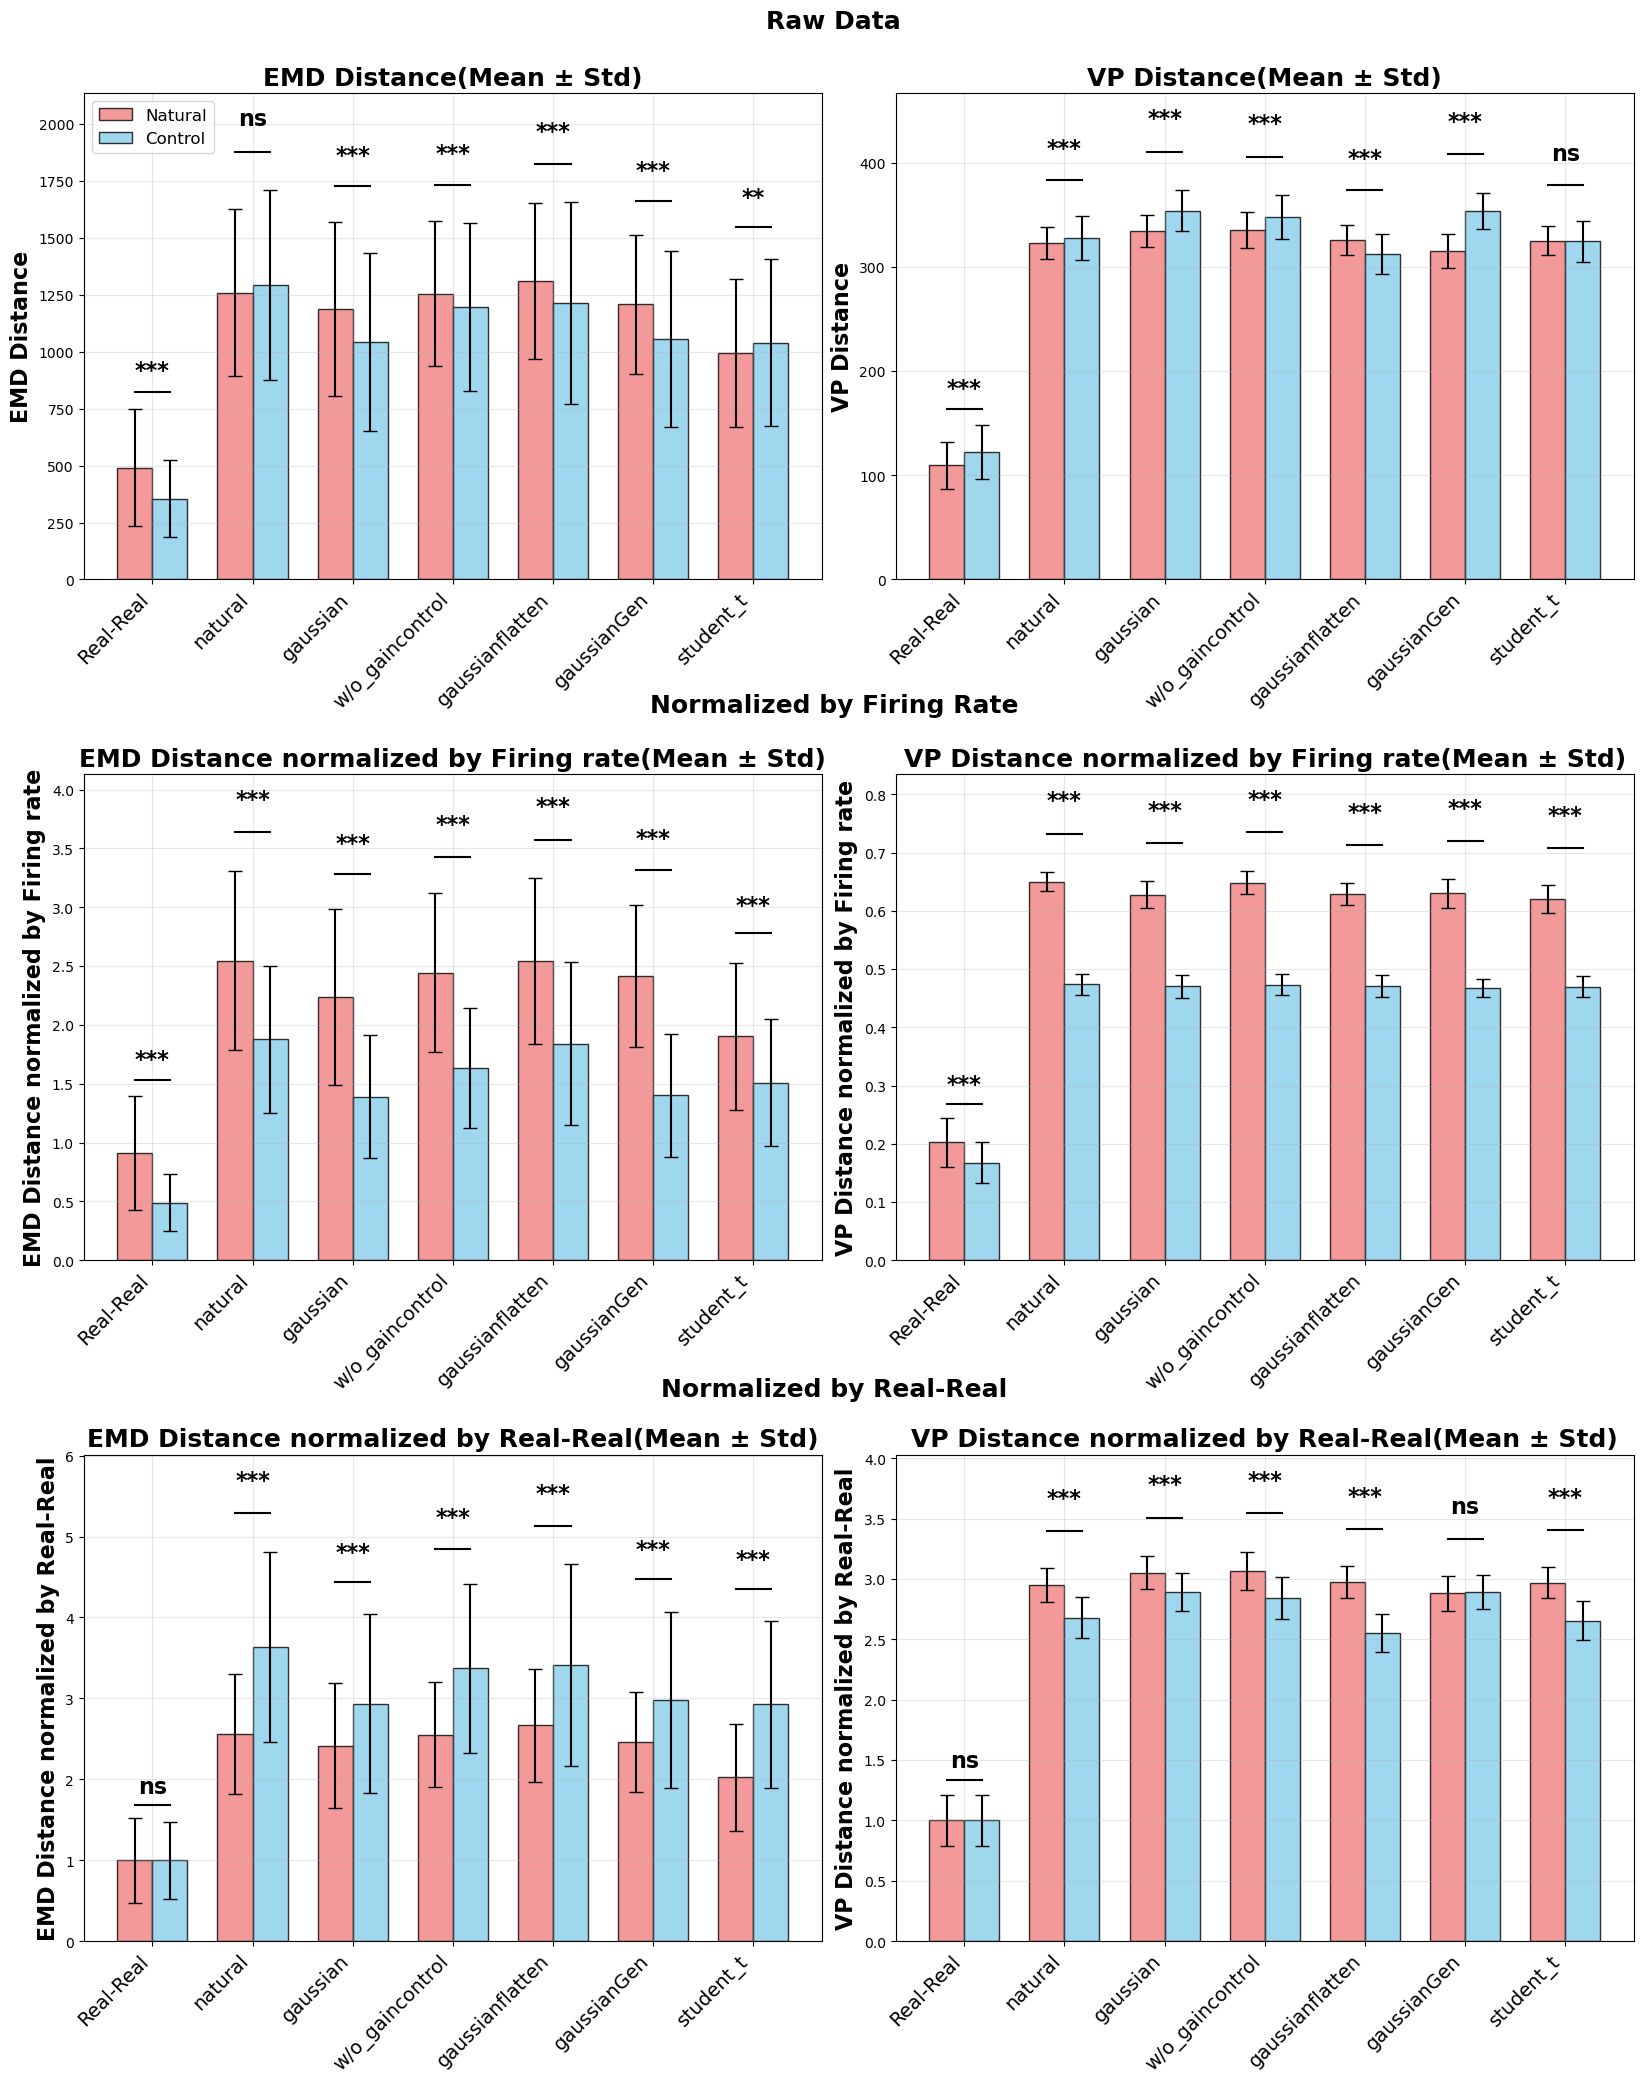

In [8]:

from scipy.stats import ttest_ind, mannwhitneyu

# Define significance thresholds and corresponding markers
SIGNIFICANCE_THRESHOLDS = {
    0.001: '***',  # p < 0.001: highly significant
    0.01: '**',    # p < 0.01: very significant  
    0.05: '*'      # p < 0.05: significant
}

def get_significance_marker(p_value):
    """
    Determine significance marker based on p-value thresholds.
    
    Parameters:
    p_value (float): The p-value to evaluate
    
    Returns:
    str: Significance marker ('***', '**', '*', or 'ns')
    """
    for threshold, marker in SIGNIFICANCE_THRESHOLDS.items():
        if p_value < threshold:
            return marker
    return 'ns'  # Not significant (p >= 0.05)

def print_significance_guide():
    """Print a guide explaining the significance markers and p-value ranges."""
    print("=== SIGNIFICANCE THRESHOLDS AND MARKERS ===")
    print("p < 0.001: *** (highly significant)")
    print("p < 0.01:  **  (very significant)")
    print("p < 0.05:  *   (significant)")
    print("p >= 0.05: ns  (not significant)")
    print("=" * 45)

# Print the significance guide
print_significance_guide()

# Extract data from summary_df for plotting
# Get Real-Real and Real-Model data
real_real_data = summary_df[summary_df['Block_Type'] == 'Real–Real']
real_model_data = summary_df[summary_df['Block_Type'] == 'Real–Model']

# Get unique metrics
metrics_raw = ['emd', 'vp']  # Raw data
metrics_fr_norm = ['emd_norm', 'vp_norm']  # Normalized by firing rate

# Create the 3-subplot figure with more spacing
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
plt.subplots_adjust(hspace=0.4, wspace=0.1)  # Increase spacing between subplots

metric_configs = [
    (['emd', 'vp'], ['EMD Distance', 'VP Distance']),  # Raw data
    (['emd_norm', 'vp_norm'], ['EMD Distance normalized by Firing rate', 'VP Distance normalized by Firing rate']),  # FR normalized
    (['emd', 'vp'], ['EMD Distance normalized by Real-Real', 'VP Distance normalized by Real-Real'])  # RR normalized (calculated)
]

for subplot_idx in range(3):
    for metric_idx in range(2):
        ax = axes[subplot_idx, metric_idx]
        
        if subplot_idx == 2:  # Real-Real normalization
            # Use raw metrics but normalize them
            metric = metric_configs[subplot_idx][0][metric_idx]
            metric_name = metric_configs[subplot_idx][1][metric_idx]
        else:
            metric = metric_configs[subplot_idx][0][metric_idx]
            metric_name = metric_configs[subplot_idx][1][metric_idx]
        
        # Filter data for this metric
        metric_data = summary_df[summary_df['Metric'] == metric]
        real_model_metric = metric_data[metric_data['Block_Type'] == 'Real–Model']
        real_real_metric = metric_data[metric_data['Block_Type'] == 'Real–Real']
        
        if real_model_metric.empty:
            continue
        
        # Get Real-Real values and p-value
        rr_nat_mean = float(real_real_metric.iloc[0]['Natural_Mean'])
        rr_ctrl_mean = float(real_real_metric.iloc[0]['Control_Mean'])
        rr_nat_std = float(real_real_metric.iloc[0]['Natural_std'])
        rr_ctrl_std = float(real_real_metric.iloc[0]['Control_std'])
        rr_p_value = float(real_real_metric.iloc[0]['P_value_T'])
        
        # Extract Real-Model data for each condition
        conditions = []
        nat_means_rm = []
        ctrl_means_rm = []
        nat_stds_rm = []
        ctrl_stds_rm = []
        p_values = []
        
        for _, row in real_model_metric.iterrows():
            condition = row['Comparison'].split(' vs ')[0].replace('natural_', '')
            conditions.append(condition)
            
            nat_mean = float(row['Natural_Mean'])
            ctrl_mean = float(row['Control_Mean'])
            nat_std = float(row['Natural_std'])
            ctrl_std = float(row['Control_std'])
            
            # For Real-Real normalization (subplot 2), normalize the values
            if subplot_idx == 2:
                nat_mean = nat_mean / rr_nat_mean
                ctrl_mean = ctrl_mean / rr_ctrl_mean
                nat_std = nat_std / rr_nat_mean
                ctrl_std = ctrl_std / rr_ctrl_mean
                # Also normalize Real-Real values
                rr_nat_mean_norm = 1.0
                rr_ctrl_mean_norm = 1.0
                rr_nat_std_norm = rr_nat_std / rr_nat_mean
                rr_ctrl_std_norm = rr_ctrl_std / rr_ctrl_mean
                
                # Calculate p-value for normalized data
                # We need to get the raw data to calculate p-values for normalized values
                nat_data_raw = all_results[row['Comparison'].split(' vs ')[0]][f'{metric}_stats']
                ctrl_data_raw = all_results[row['Comparison'].split(' vs ')[1]][f'{metric}_stats']
                
                # Get Real-Model data for both natural and control
                nat_rm_data = [stat['data'] for stat in nat_data_raw if stat['label'] == 'Real–Model'][0]
                ctrl_rm_data = [stat['data'] for stat in ctrl_data_raw if stat['label'] == 'Real–Model'][0]

                # Get Real-Real data for both natural and control
                nat_rr_data = [stat['data'] for stat in nat_data_raw if stat['label'] == 'Real–Real'][0]
                ctrl_rr_data = [stat['data'] for stat in ctrl_data_raw if stat['label'] == 'Real–Real'][0]
                
                # Normalize the raw data
                nat_rm_norm = np.array(nat_rm_data) / np.mean(nat_rr_data)
                ctrl_rm_norm = np.array(ctrl_rm_data) / np.mean(ctrl_rr_data)
                
                # Calculate p-value for normalized data using t-test
                t_stat_norm, p_val_norm = ttest_ind(nat_rm_norm, ctrl_rm_norm)
                p_values.append(p_val_norm)
                
            else:
                rr_nat_mean_norm = rr_nat_mean
                rr_ctrl_mean_norm = rr_ctrl_mean
                rr_nat_std_norm = rr_nat_std
                rr_ctrl_std_norm = rr_ctrl_std
                p_values.append(float(row['P_value_T']))
            
            nat_means_rm.append(nat_mean)
            ctrl_means_rm.append(ctrl_mean)
            nat_stds_rm.append(nat_std)
            ctrl_stds_rm.append(ctrl_std)
        
        # Position Real-Real at x=0, Real-Model conditions starting at x=1
        x_rr = 0
        x_rm = np.arange(1, len(conditions) + 1)
        width = 0.35
        
        # Plot Real-Real bars (single bar) - SWAPPED COLORS
        ax.bar(x_rr - width/2, rr_nat_mean_norm, width, yerr=rr_nat_std_norm, capsize=5,
               facecolor='lightcoral', edgecolor='black', label='Natural', alpha=0.8)
        ax.bar(x_rr + width/2, rr_ctrl_mean_norm, width, yerr=rr_ctrl_std_norm, capsize=5,
               facecolor='skyblue', edgecolor='black', label='Control', alpha=0.8)
        
        # Add p-value annotation for Real-Real using significance function
        if subplot_idx == 2:
            # For Real-Real normalized, both should be 1.0, so p-value should be ns
            rr_sig_text = 'ns'
        else:
            # Use original p-value for raw and firing rate normalized
            rr_sig_text = get_significance_marker(rr_p_value)
        
        # Calculate positions for Real-Real line
        rr_y_max = max(rr_nat_mean_norm + rr_nat_std_norm, rr_ctrl_mean_norm + rr_ctrl_std_norm)
        rr_line_y = rr_y_max + rr_y_max * 0.1
        
        # Draw horizontal line for Real-Real
        ax.plot([x_rr - width/2, x_rr + width/2], [rr_line_y, rr_line_y], 
                'k-', linewidth=1.5)
        
        # Add significance text for Real-Real
        ax.text(x_rr, rr_line_y + rr_line_y * 0.05, rr_sig_text, ha='center', va='bottom', 
                fontsize=16, fontweight='bold')
        
        # Plot Real-Model bars - SWAPPED COLORS
        ax.bar(x_rm - width/2, nat_means_rm, width, yerr=nat_stds_rm, capsize=5,
               facecolor='lightcoral', edgecolor='black', alpha=0.8)
        ax.bar(x_rm + width/2, ctrl_means_rm, width, yerr=ctrl_stds_rm, capsize=5,
               facecolor='skyblue', edgecolor='black', alpha=0.8)
        
        # Add p-value annotations with horizontal lines for Real-Model comparisons
        for i, p_val in enumerate(p_values):
            if p_val < 0.001:
                sig_text = '***'
            elif p_val < 0.01:
                sig_text = '**'
            elif p_val < 0.05:
                sig_text = '*'
            else:
                sig_text = 'ns'
            
            # Calculate positions for horizontal line
            y_max = max(nat_means_rm[i] + nat_stds_rm[i], ctrl_means_rm[i] + ctrl_stds_rm[i])
            line_y = y_max + y_max * 0.1
            
            # Draw horizontal line
            ax.plot([x_rm[i] - width/2, x_rm[i] + width/2], [line_y, line_y], 
                    'k-', linewidth=1.5)
            
            # Add significance text
            ax.text(x_rm[i], line_y + line_y * 0.05, sig_text, ha='center', va='bottom', 
                    fontsize=16, fontweight='bold')
        
        ax.set_ylabel(metric_name, fontsize=16, fontweight='bold')
        ax.set_title(f'{metric_name}(Mean ± Std)', fontsize=18, fontweight='bold')
        if subplot_idx == 0 and metric_idx == 0:  # Only show legend for first subplot
            ax.legend(loc='upper left', fontsize=12)
        ax.grid(True, alpha=0.3)
        


        ax.set_xticks(np.concatenate([[x_rr], x_rm]))
        ax.set_xticklabels(['Real-Real'] + conditions, rotation=45, ha='right', fontsize=14)

        
        # Adjust y-axis limits
        all_means = [rr_nat_mean_norm, rr_ctrl_mean_norm] + nat_means_rm + ctrl_means_rm
        all_stds = [rr_nat_std_norm, rr_ctrl_std_norm] + nat_stds_rm + ctrl_stds_rm
        y_max_all = max([m + s for m, s in zip(all_means, all_stds)])
        ax.set_ylim(0, y_max_all * 1.25)

# Add overall titles for each row with more spacing
fig.text(0.5, 0.91, 'Raw Data', ha='center', va='center', fontsize=18, fontweight='bold')
fig.text(0.5, 0.625, 'Normalized by Firing Rate', ha='center', va='center', fontsize=18, fontweight='bold')
fig.text(0.5, 0.34, 'Normalized by Real-Real', ha='center', va='center', fontsize=18, fontweight='bold')

plt.show()

